In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. K-Nearest Neighbours

K-Nearest Neighbours (KNN) is a straightforward, instance-based learning algorithm used for both classification and regression tasks. This algorithm identifies the class or value of a new data point by locating the 'K' closest training examples in the feature space and making a decision based on these neighbours. Essentially, KNN measures the similarity between a new sample and existing data points to predict its class or value.

As a supervised model, KNN is generally considered non-parametric because it involves minimal parameter tuning. *This makes it flexible in scenarios where the decision boundary is highly irregular*.

However, KNN requires the computation of proximity measures between the point to be predicted and the entire input dataset, making it memory and computationally intensive. This can be a drawback for large datasets, but it is well-suited for cases where the decision boundaries are complex and not easily defined by parametric models.


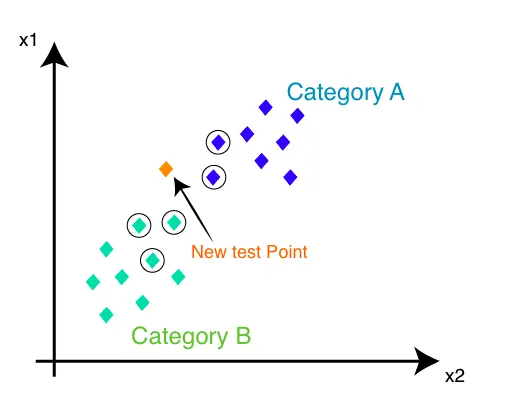

In [ ]:
from PIL import Image
Image.open('/content/drive/MyDrive/Class 25-26/3.Images/8. knn/knn.webp')

# 2.  Fitting a KNN model

Let's consider the Iris dataset that we employed when learning about decision trees. The following code will load the iris dataset and split it into 30% test data and 70% training data:


In [10]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

iris = load_iris()
X, y = iris.data[:, 2:], iris.target      # only petal length and petal width as features.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=123,
                                                    shuffle=True)

In [11]:
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (105, 2)
y_train.shape: (105,)
X_test.shape: (45, 2)
y_test.shape: (45,)


Even though this is a small dataset, standardising the features improves KNN performance and makes distance meaningful.

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

As we have learnt, it is always a good idea to visualise your data before doing any further analyses. We can create a scatter plot using matplotlib:

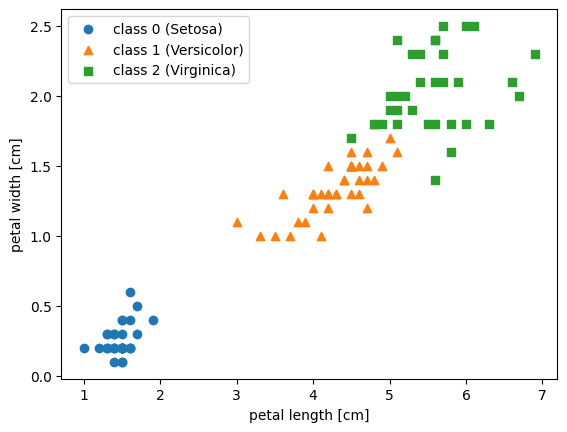

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(X_train[y_train == 0, 0],
            X_train[y_train == 0, 1],
            marker='o',
            label='class 0 (Setosa)')

plt.scatter(X_train[y_train == 1, 0],
            X_train[y_train == 1, 1],
            marker='^',
            label='class 1 (Versicolor)')

plt.scatter(X_train[y_train == 2, 0],
            X_train[y_train == 2, 1],
            marker='s',
            label='class 2 (Virginica)')

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')

plt.show()

Q: What can you learn about this dataset? Pay close attention to the two axes ...

Next, we "fit" a KNN model to the training dataset with k = 2:

In [13]:
from sklearn.neighbors import KNeighborsClassifier


knn_model = KNeighborsClassifier(n_neighbors=2)
knn_model.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=2)

After "fitting" the KNN model, we can now make predictions on new data points that the model has not seen before. The test set represents such data points. Of course, we have labels for the test set as well, but we only use these labels to evaluate the model -- i.e., we compare the predictions to the true labels in the test set in order to find out how good the model is:

In [14]:
y_pred = knn_model.predict(X_test_scaled)

In [15]:
print(f'Test set accuracy: {knn_model.score(X_test_scaled, y_test)*100:.2f}%')

Test set accuracy: 91.11%


We can now visualise the decision boundary of the model. For that, we will use the mlxtend.plotting.plot_decision_regions function in mlxtend (Machine Learning Extensions), which computes decision regions by evaluating the model’s predictions over a grid of points in the feature space. mlxtend.plotting.plot_decision_regions evaluates the classifier across a dense grid of input points, then plots the resulting predictions as colored regions to show where the model classifies each part of the space.

Let's visualise the decision boundaries and the classification of examples in the test set.

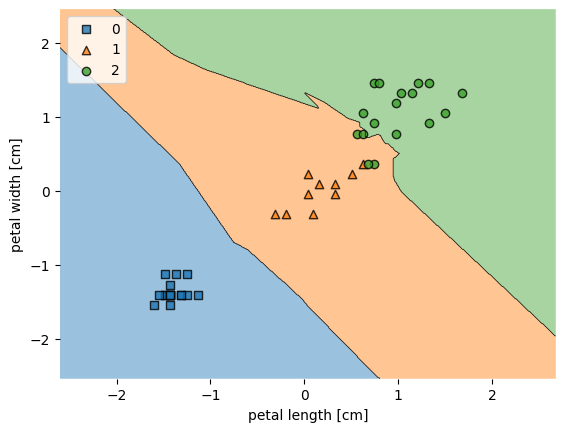

In [16]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt

plot_decision_regions(X_test_scaled, y_test, knn_model)
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.show()

Let's visualise now the classification of examples in the training set.

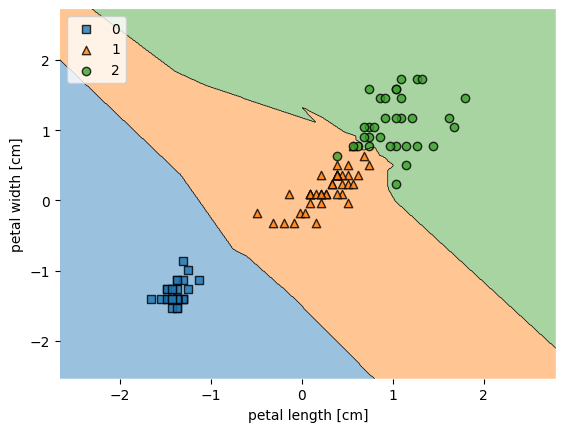

In [17]:
from mlxtend.plotting import plot_decision_regions


plot_decision_regions(X_train_scaled, y_train, knn_model)
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.show()

# 3. Determining the Optimal K in K-Nearest Neighbours (KNN)


Selecting the optimal number of neighbours, \(K\), is crucial for the performance of the KNN algorithm. The choice of \(K\) affects the algorithm's ability to generalise from the training data to unseen data. Here are some methods and considerations to determine the most optimal \(K\):

#### 3.1 Understanding the Impact of \(K\)

- **Small \(K\) (e.g., \(K=1\))**:
  - Leads to a model that is sensitive to noise in the data.
  - Can result in overfitting, where the model captures noise along with the underlying pattern.

- **Large \(K\)**:
  - Results in smoother decision boundaries and less sensitivity to noise.
  - Can lead to underfitting, where the model is too simple to capture the underlying patterns.


#### 3.2 Cross-Validation Method with grid search for K-nearest neighbour classifier

Cross-validation is a robust method for selecting the optimal number of neighbours \(K\).

- Note that feature scaling is necessary for KNN.
- To avoid introducing bias, we have to compute the parameters for scaling (e.g., the mean and standard deviation in the context of z-score normalisation) on the training fold to scale the training AND test fold in a given iteration.
- To make this more convenient, this is where scikit-learn's `Pipeline` class (or `make_pipeline` function) comes in handy, as the next cell demonstrates.

In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

pipe = make_pipeline(StandardScaler(),
                     KNeighborsClassifier())

# since we're using a pipeline, we have to prepend each parameter's name in the grid
# with the name of the model in the pipe: kneighborsclassifier corresponds to KNeighborsClassifier
k_values = list(range(1, 11))
param_grid = [{'kneighborsclassifier__n_neighbors': k_values}]

gs = GridSearchCV(estimator=pipe,
                  param_grid=param_grid,
                  n_jobs=-1,
                  cv=10) # k-fold cross-validation with k=10

knn_model = gs.fit(X_train_scaled, y_train)

print('Best CV Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best k value (number of neighbours):', gs.best_params_['kneighborsclassifier__n_neighbors'])
print('Test Accuracy: %.2f%%' % (gs.best_estimator_.score(X_test_scaled, y_test)*100))

Best CV Accuracy: 97.18%
Best k value (number of neighbours): 4
Test Accuracy: 95.56%


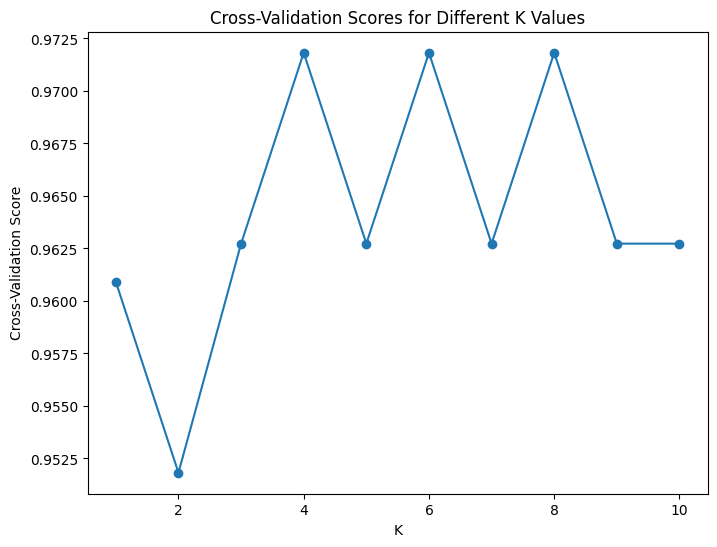

In [19]:
import pandas as pd

cross_val_scores = gs.cv_results_['mean_test_score']

# Plot cross-validation scores
plt.figure(figsize=(8, 6))
plt.plot(k_values, cross_val_scores, marker='o')
plt.xlabel('K')
plt.ylabel('Cross-Validation Score')
plt.title('Cross-Validation Scores for Different K Values')
plt.show()

It turns ou that $k=2$ was a bad decision, and the knn classifier can be improved with $k=4$.

Let's visualise the decision regions and classifications for the test set.

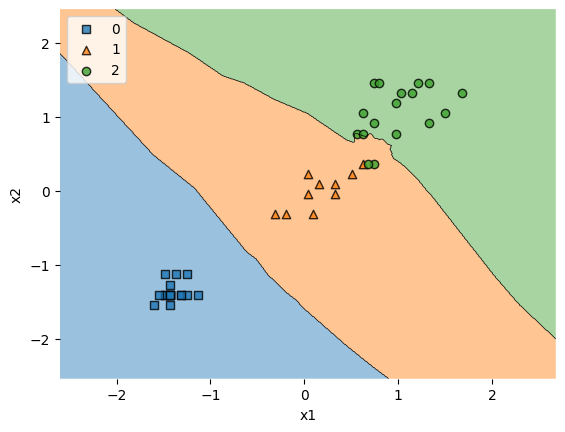

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions

best_knn_model = gs.best_estimator_

# Plot decision regions
plot_decision_regions(X_test_scaled, y_test, best_knn_model)
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(loc='upper left')
plt.show()



Let's visualise the decision regions and classifications for the training set.

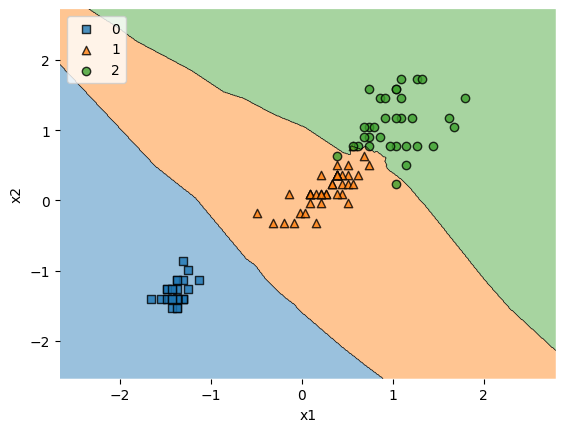

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions

best_knn_model = gs.best_estimator_

# Plot decision regions
plot_decision_regions(X_train_scaled, y_train, best_knn_model)
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(loc='upper left')
plt.show()
